# Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Carregando a base de dados

In [2]:
df = pd.read_csv('a20n.csv', decimal=',', sep=';')
df.head()

,sg_empresa_icao,dt_referencia,sg_icao_origem,sg_equipamento_icao,ds_modelo,ds_matricula,sg_icao_destino,lt_combustivel,nr_assentos_ofertados,kg_payload,...,nr_pax_gratis_km,nr_carga_paga_km,nr_carga_gratis_km,nr_correio_km,nr_bagagem_paga_km,nr_bagagem_gratis_km,nr_ask,nr_rpk,nr_atk,nr_rtk
0,AZU,2021-01-01,SBRJ,A20N,AIRBUS A320NEO,YRX,SBGO,4185.0,174,15483,...,943.0,0.0,0.0,0.0,10373.0,933570.0,164082.0,115989.0,14600.0,9643.0
1,AZU,2021-01-01,SBSV,A20N,AIRBUS A320NEO,YYJ,SBCF,4324.0,165,17843,...,959.0,1918.0,0.0,0.0,36442.0,1426030.0,158235.0,154399.0,17111.0,13044.0
2,AZU,2021-01-01,SBSP,A20N,AIRBUS A320NEO,YRF,SBRF,8081.0,174,18203,...,0.0,61741.0,0.0,0.0,61741.0,2967830.0,370446.0,336382.0,38754.0,28319.0
3,AZU,2021-01-01,SBSL,A20N,AIRBUS A320NEO,YRQ,SBRF,4603.0,174,19242,...,0.0,70859.0,0.0,0.0,40834.0,1456810.0,208974.0,181351.0,23109.0,15169.0
4,AZU,2021-01-01,SBCF,A20N,AIRBUS A320NEO,YSD,SBSV,3849.0,174,18206,...,2877.0,223447.0,0.0,0.0,48909.0,1041470.0,166866.0,146727.0,17459.0,12318.0


# Explorando a base de dados

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53570 entries, 0 to 53569
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sg_empresa_icao        53570 non-null  object 
 1   dt_referencia          53570 non-null  object 
 2   sg_icao_origem         53570 non-null  object 
 3   sg_equipamento_icao    53570 non-null  object 
 4   ds_modelo              53570 non-null  object 
 5   ds_matricula           53570 non-null  object 
 6   sg_icao_destino        53570 non-null  object 
 7   lt_combustivel         53570 non-null  float64
 8   nr_assentos_ofertados  53570 non-null  int64  
 9   kg_payload             53570 non-null  int64  
 10  km_distancia           53570 non-null  float64
 11  nr_passag_pagos        53570 non-null  float64
 12  nr_passag_gratis       53570 non-null  float64
 13  kg_bagagem_livre       53570 non-null  float64
 14  kg_bagagem_excesso     53570 non-null  float64
 15  kg

Podemos ver que nenhuma das colunas da base de dados possui valores nulos. Assim não precisamos fazer qualquer tipo de tratamento nesse sentido na base de dados.

## Descrição das variáveis utilizadas

Quanto aos dados existentes na base de dados, temos segundo a ANAC as definições para cada variável:


* sg_empresa_icao - Sigla ICAO da empresa aérea. Refere-se ao designador da empresa de transporte aéreo obtido junto à OACI (Organização da Aviação Civil Internacional).

* dt_referencia - Data de Referência. Corresponde à Data Prevista de Início do Voo.

* sg_icao_origem - Sigla ICAO do aeródromo de origem.

* sg_equipamento_icao - Designador ICAO do modelo da aeronave (“Type Designator”)

* ds_modelo - Descrição do modelo da aeronave.

* ds_matricula - Marca de matrícula da aeronave.

* sg_icao_destino - Código identificador do aeródromo de destino no sistema.

* lt_combustivel - Quantidade de combustível consumida, expressa em litros.

* nr_assentos_ofertados - Número de assentos disponíveis na etapa do voo.

* kg_payload - Capacidade Payload, expressa em quilogramas.

* km_distancia - Distância, expressa em quilômetros, entre os aeródromos de origem e destino da etapa, considerando a curvatura do planeta terra.

* nr_passag_pagos - Número de passageiros que ocupam assentos comercializados ao público e que geram receita, com a compra de assentos, para a empresa de transporte aéreo.

* nr_passag_gratis - Número de passageiros que ocupam assentos comercializados ao público, mas não geram receita, com a compra de assentos, para a empresa de transporte aéreo.

* kg_bagagem_livre - Bagagem franqueada. É toda bagagem que não é considerada como excesso, expressa em quilogramas.

* kg_bagagem_excesso - Excesso de bagagem. É a quantidade total de bagagem que excede o limite de peso acordado entre a empresa aérea e o passageiro (adquirido antes ou depois da compra do bilhete), verificada no momento do despacho, expressa em quilogramas.

* kg_carga_paga - Carga paga. É a quantidade total, expressa em quilogramas, de todos os bens que tenham sido transportados na aeronave, exceto correio e bagagem, e tenham gerado receita direta ou indireta para a empresa aérea. 

* kg_carga_gratis - Quantidade total, expressa em quilogramas, de todos os bens que tenham sido transportados na aeronave, exceto correio e bagagem, e não tenha gerado receitas diretas ou indiretas para a empresa aérea.

* kg_correio - Quantidade, expressa em quilogramas, de objetos transportados para atender aos operadores designados oficialmente pelo país para operar serviços postais e cumprir com as obrigações associadas decorrentes dos Atos da Universal Postal Union (UPU).

* nr_decolagem - Número de decolagens.

* nr_horas_voadas - Número de horas voadas.

* kg_peso - Refere-se ao peso total carregado pela aeronave, calculado pela soma de carga, correio, passageiros e bagagem, expressos em kg. O peso dos passageiros transportados é calculado multiplicando-se a quantidade total de passageiros por 75, para empresas brasileiras. No caso das empresas estrangeiras, que não enviam dados de bagagem à ANAC, o peso total de passageiros e bagagens é estimado multiplicando-se a quantidade total de passageiros por 90.

* nr_velocidade_media - Velocidade média do voo, calculada a partir da distância e da duração do voo, expressa em km/h.

* nr_pax_gratis_km - Representa, para cada etapa básica, o produto entre a quantidade de passageiros grátis e a distância da etapa.

* nr_carga_paga_km - Refere-se ao produto entre a quantidade de carga paga (kg) e a distância da etapa básica (km).

* nr_carga_gratis_km - Refere-se ao produto entre a quantidade de carga grátis (kg) e a distância da etapa básica (km).

* nr_correio_km - Refere-se ao produto entre a quantidade de correio (kg) e a distância da etapa básica (km).

* nr_bagagem_paga_km - Refere-se ao produto entre a quantidade de bagagem paga (kg) e a distância da etapa básica (km).

* nr_bagagem_gratis_km - Refere-se ao produto entre a quantidade de bagagem grátis (kg) e a distância da etapa básica (km).

* nr_ask - Refere-se ao volume de Assentos Quilômetros Oferecidos (Available Seat Kilometer). É calculado, em cada etapa básica, pelo produto entre o número de assentos oferecidos e a distância da etapa.

* nr_rpk - Refere-se ao volume de Passageiros Quilômetros Transportados (Revenue Passenger Kilometer). É calculado, em cada etapa básica, pelo produto entre o número de passageiros pagos e a distância da etapa.

* nr_atk - Refere-se ao volume de Toneladas Quilômetros Oferecidas (Available Tonne Kilometer), expresso em (ton x km). É calculado, em cada etapa básica, pelo produto entre a Capacidade Payload (kg) e a distância da etapa, dividido por 1000.

* nr_rtk - Refere-se ao volume de Toneladas Quilômetros Transportadas (Revenue Tonne Kilometer), expresso em (ton x km). É calculado, em cada etapa básica, pelo produto entre a quantidade, expressa em quilogramas, de passageiros, bagagem, carga e correio pagos transportada e a distância da etapa, dividido por 1000. Cada passageiro possui o peso estimado de 75kg, para empresas brasileiras. No caso das empresas estrangeiras, que não enviam dados de bagagem à ANAC, o peso total de passageiros e bagagens é estimado multiplicando-se a quantidade total de passageiros por 90.

## Tamanho da base de dados

In [4]:
df.shape

(53570, 32)

Temos uma base de 53570 linhas e 32 colunas. Essa base leva em consideração somente os voos domésticos realizados pelo modelo A320neo da Azul Linhas Aéreas Brasileiras durante o ano de 2021.

# Limpeza da base de dados

Como temos algumas colunas que possuem dados categóricos, precisamos fazer uma limpeza na base. Precisamos deixar somente os dados numéricos relevantes. Primeiro vamos tirar dados como a matrícula da aeronave, dados de origem e destino (já que temos a distância percorrida, dados de origem e destino não são relevantes) e etc. Feito isso, faremos um mapa de correlação entre as variáveis para verificar quais outras variáveis são interessantes para o modelo. Outra variável que já podemos eliminar é a nr_decolagem, uma vez que sempre será 1 na nossa base pois corresponde ao voo efetuado.

In [5]:
df = df[['lt_combustivel', 'nr_assentos_ofertados', 'kg_payload', 'km_distancia',
       'nr_passag_pagos', 'nr_passag_gratis', 'kg_bagagem_livre',
       'kg_bagagem_excesso', 'kg_carga_paga', 'kg_carga_gratis', 'kg_correio',
        'nr_horas_voadas', 'kg_peso', 'nr_velocidade_media',
       'nr_pax_gratis_km', 'nr_carga_paga_km', 'nr_carga_gratis_km',
       'nr_correio_km', 'nr_bagagem_paga_km', 'nr_bagagem_gratis_km', 'nr_ask',
       'nr_rpk', 'nr_atk', 'nr_rtk']]
df.head()

,lt_combustivel,nr_assentos_ofertados,kg_payload,km_distancia,nr_passag_pagos,nr_passag_gratis,kg_bagagem_livre,kg_bagagem_excesso,kg_carga_paga,kg_carga_gratis,...,nr_pax_gratis_km,nr_carga_paga_km,nr_carga_gratis_km,nr_correio_km,nr_bagagem_paga_km,nr_bagagem_gratis_km,nr_ask,nr_rpk,nr_atk,nr_rtk
0,4185.0,174,15483,943.0,123.0,1.0,990.0,11.0,0.0,0.0,...,943.0,0.0,0.0,0.0,10373.0,933570.0,164082.0,115989.0,14600.0,9643.0
1,4324.0,165,17843,959.0,161.0,1.0,1487.0,38.0,2.0,0.0,...,959.0,1918.0,0.0,0.0,36442.0,1426030.0,158235.0,154399.0,17111.0,13044.0
2,8081.0,174,18203,2129.0,158.0,0.0,1394.0,29.0,29.0,0.0,...,0.0,61741.0,0.0,0.0,61741.0,2967830.0,370446.0,336382.0,38754.0,28319.0
3,4603.0,174,19242,1201.0,151.0,0.0,1213.0,34.0,59.0,0.0,...,0.0,70859.0,0.0,0.0,40834.0,1456810.0,208974.0,181351.0,23109.0,15169.0
4,3849.0,174,18206,959.0,153.0,3.0,1086.0,51.0,233.0,0.0,...,2877.0,223447.0,0.0,0.0,48909.0,1041470.0,166866.0,146727.0,17459.0,12318.0


# Mapa de correlações

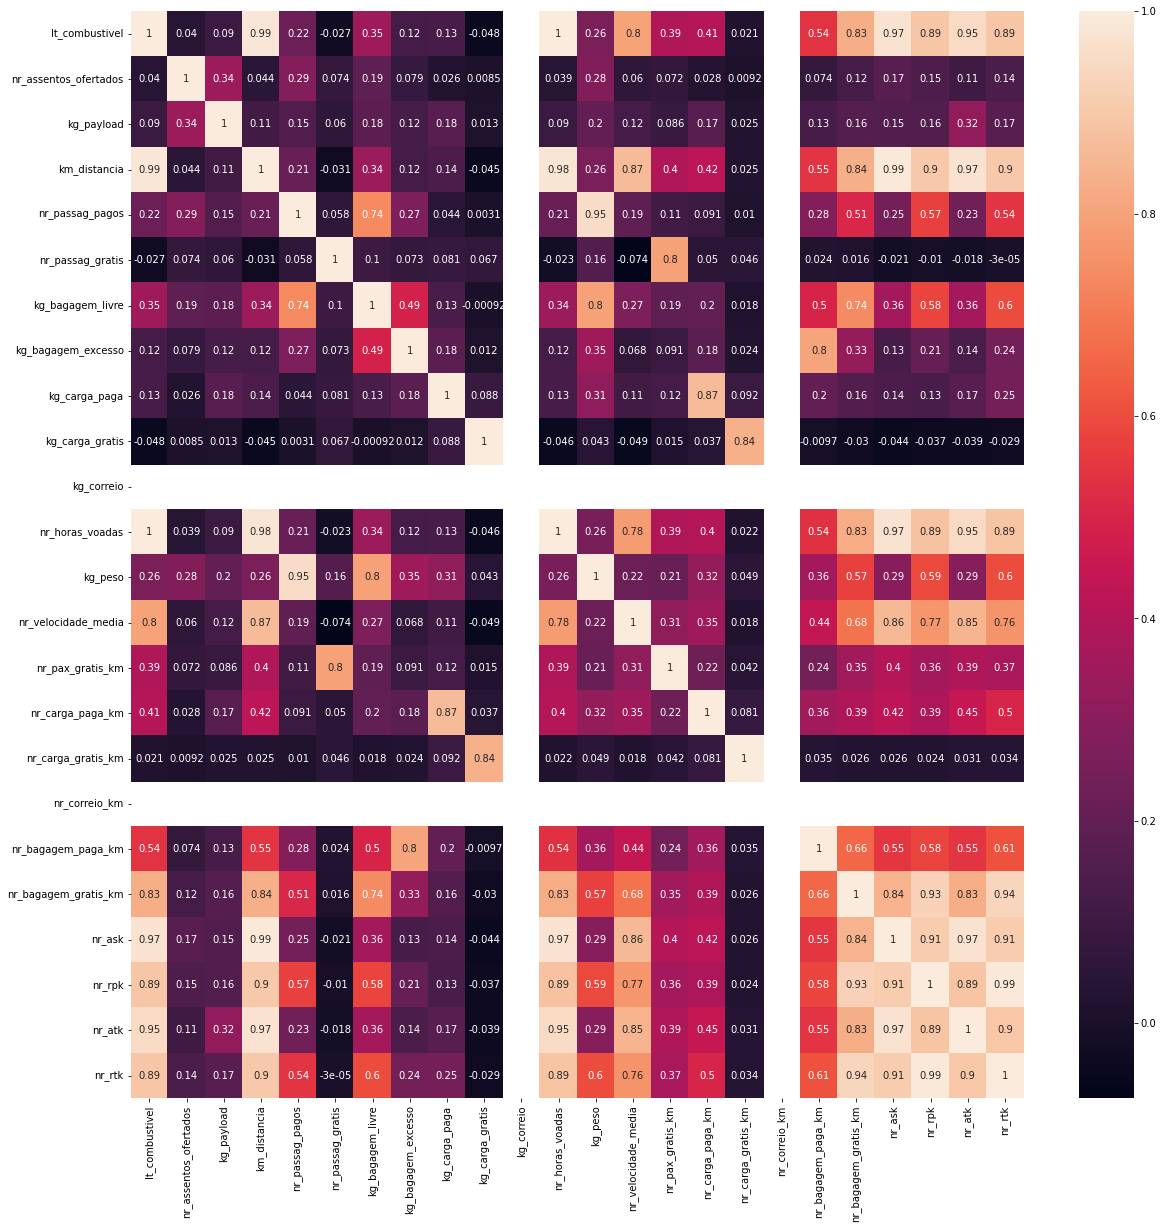

In [6]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

Podemos ver que pelo mapa de correlações, já podemos descartar as variáveis kg_correio e nr_correio_km pois já aparecem como sendo variáveis nulas para as correlações com a quantidade de combustível consumido.

Para o nosso estudo, vamos considerar somente as variáveis com correlações acima de 0.5 com o consumo de combustível. Assim, as variáveis a serem utilizadas além, claro, da variável alvo de consumo de combustível são:

- km_distancia = 0.99
- nr_horas_voadas = 1
- nr_velocidade_media = 0.8
- nr_bagagem_paga_km = 0.54
- nr_bagagem_gratis_km = 0.83
- nr_ask = 0.97
- nr_rpk = 0.89
- nr_atk = 0.95
- nr_rtk = 0.89

In [7]:
df = df[['lt_combustivel', 'km_distancia', 'nr_horas_voadas', 'nr_velocidade_media', 'nr_bagagem_paga_km', 'nr_bagagem_gratis_km',
         'nr_ask', 'nr_rpk', 'nr_atk', 'nr_rtk']]

df

,lt_combustivel,km_distancia,nr_horas_voadas,nr_velocidade_media,nr_bagagem_paga_km,nr_bagagem_gratis_km,nr_ask,nr_rpk,nr_atk,nr_rtk
0,4185.0,943.0,1.66667,565.58,10373.0,933570.0,164082.0,115989.0,14600.0,9643.0
1,4324.0,959.0,1.76667,543.11,36442.0,1426030.0,158235.0,154399.0,17111.0,13044.0
2,8081.0,2129.0,3.16667,672.34,61741.0,2967830.0,370446.0,336382.0,38754.0,28319.0
3,4603.0,1201.0,1.81667,660.93,40834.0,1456810.0,208974.0,181351.0,23109.0,15169.0
4,3849.0,959.0,1.53333,625.75,48909.0,1041470.0,166866.0,146727.0,17459.0,12318.0
...,...,...,...,...,...,...,...,...,...,...
53565,7467.0,2129.0,2.83333,751.44,172449.0,2659120.0,351285.0,300189.0,33974.0,25345.0
53566,2457.0,499.0,1.08333,460.37,30439.0,775446.0,86826.0,67864.0,8161.0,6007.0
53567,7733.0,2101.0,2.96667,708.16,136565.0,3204020.0,365574.0,327756.0,40057.0,27922.0
53568,7676.0,2048.0,2.93333,698.35,206848.0,2750460.0,356352.0,284672.0,37906.0,24502.0


# Separação das variáveis entre features e labels

Para fazer a separação, já utilizarei o método .values, assim a base já se converte automaticamente para arrays numpy.

In [8]:
previsores = df.iloc[:,1:].values
consumo = df.iloc[:,0].values

In [9]:
type(previsores), type(consumo)

(numpy.ndarray, numpy.ndarray)

# Normalizando os dados

Como temos dados com escalas muito diferentes, precisamos colocar todos esses dados na mesma escala para que o modelo consiga fazer o treinamento e a predição sem fazer diferenciação entre as variáveis. Para isso utilizaremos o médod do MinMaxScaler do sklearn.

In [10]:
normalizador_previsores = MinMaxScaler()
normalizador_consumo = MinMaxScaler()


In [11]:
previsores = normalizador_previsores.fit_transform(previsores)
consumo = normalizador_consumo.fit_transform(consumo.reshape(-1,1))

In [12]:
previsores

array([[0.2673934 , 0.2788111 , 0.17329366, ..., 0.22497585, 0.2372672 ,
        0.18099403],
       [0.27252324, 0.30111593, 0.16435468, ..., 0.29947708, 0.27807391,
        0.24482901],
       [0.64764348, 0.61338361, 0.21576475, ..., 0.65245693, 0.62979816,
        0.53153272],
       ...,
       [0.63866624, 0.56877395, 0.2300146 , ..., 0.63572567, 0.65097345,
        0.52408123],
       [0.62167361, 0.56133751, 0.226112  , ..., 0.55215862, 0.61601716,
        0.45988964],
       [0.56268035, 0.49442301, 0.22995891, ..., 0.37239362, 0.45119771,
        0.31318743]])

In [13]:
consumo

array([[0.2812076 ],
       [0.29299525],
       [0.61160109],
       ...,
       [0.58208955],
       [0.57725577],
       [0.51526459]])

Podemos ver agora que todos os dados possuem a mesma escala.

# Separando entre dados de treino e teste

In [14]:
x_train, x_test, y_train, y_test = train_test_split(previsores, consumo, test_size=0.25, shuffle=True)

In [15]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((40177, 9), (13393, 9), (40177, 1), (13393, 1))

Com a base devidamente separada entre dados de treino e teste, podemos agora construir nosso modelo.

# Construindo o modelo

In [16]:
model = Sequential()
model.add(Dense(units = 500, activation='relu', input_dim=9))
model.add(Dropout(0.25))
model.add(Dense(units=500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=500, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(units=1, activation='sigmoid'))

In [17]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

Colocarei alguns callbacks do pacote do keras que são eles:

EarlyStopping = O treinamento se encerra com antecedência caso não haja melhoria significativa durante algumas épocas.
ReduceLROnPlateu = Altera a taxa de aprendizado do modelo caso não haja melhoria significativa durante algumas épocas.
ModelCheckpoint = Salva automaticamente os pesos da rede neural a cada melhoria do modelo.

In [18]:
es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath = 'pesos.h5', monitor = 'loss', 
                      save_best_only = True, verbose = 1)

In [19]:
model.fit(x_train, y_train, epochs=100, batch_size=50, callbacks=[es, rlr, mcp])

Epoch 1/100
797/804 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0251
Epoch 1: loss improved from inf to 0.00151, saving model to pesos.h5
804/804 [==============================] - 8s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0251 - lr: 0.0010
Epoch 2/100
802/804 [============================>.] - ETA: 0s - loss: 5.5500e-04 - mean_absolute_error: 0.0179
Epoch 2: loss improved from 0.00151 to 0.00055, saving model to pesos.h5
804/804 [==============================] - 4s 5ms/step - loss: 5.5449e-04 - mean_absolute_error: 0.0179 - lr: 0.0010
Epoch 3/100
797/804 [============================>.] - ETA: 0s - loss: 5.1708e-04 - mean_absolute_error: 0.0173
Epoch 3: loss improved from 0.00055 to 0.00052, saving model to pesos.h5
804/804 [==============================] - 4s 5ms/step - loss: 5.1681e-04 - mean_absolute_error: 0.0173 - lr: 0.0010
Epoch 4/100
801/804 [============================>.] - ETA: 0s - loss: 5.0531e-04 - mean_absolute_error: 0

# Fazendo as predições

In [20]:
pred = model.predict(x_test)

# Avaliando o modelo

In [21]:
print('O modelo obteve um R2 Score de {:.2f}%'.format(r2_score(pred, y_test)))

O modelo obteve um R2 Score de 0.99%


In [22]:
print('O erro médio quadrático do modelo foi de {:.5f}'.format(mean_squared_error(pred, y_test)))

O erro médio quadrático do modelo foi de 0.00034


Com base nas métricas obtidas acima, o modelo pode explicar o consumo de combustível com 99% de precisão com base nas variáveis utilizadas, e tivemos um erro médio quadrático de 0.00034.

# Visualizando os dados obtidos

In [29]:
pred_final = pred.reshape(13393)

In [30]:
real = y_test.reshape(13393)

In [41]:
final = pd.DataFrame(columns=['Real', 'Previsão'])

In [42]:
final['Real'] = real

In [43]:
final['Previsão'] = pred_final

In [44]:
final.head()

,Real,Previsão
0,0.190723,0.186215
1,0.192758,0.196557
2,0.482870,0.457500
3,0.118894,0.129587
4,0.176984,0.187116


In [45]:
final.sort_values(by='Real', inplace=True)
final.head()

,Real,Previsão
5138,0.000000,0.031077
3524,0.001018,0.031934
10607,0.005597,0.187783
2631,0.031462,0.041316
3409,0.037398,0.047649


In [46]:
final.reset_index(inplace=True, drop=True)

In [48]:
final.reset_index(inplace=True, drop=False)

In [49]:
final.head()

,index,Real,Previsão
0,0,0.000000,0.031077
1,1,0.001018,0.031934
2,2,0.005597,0.187783
3,3,0.031462,0.041316
4,4,0.037398,0.047649


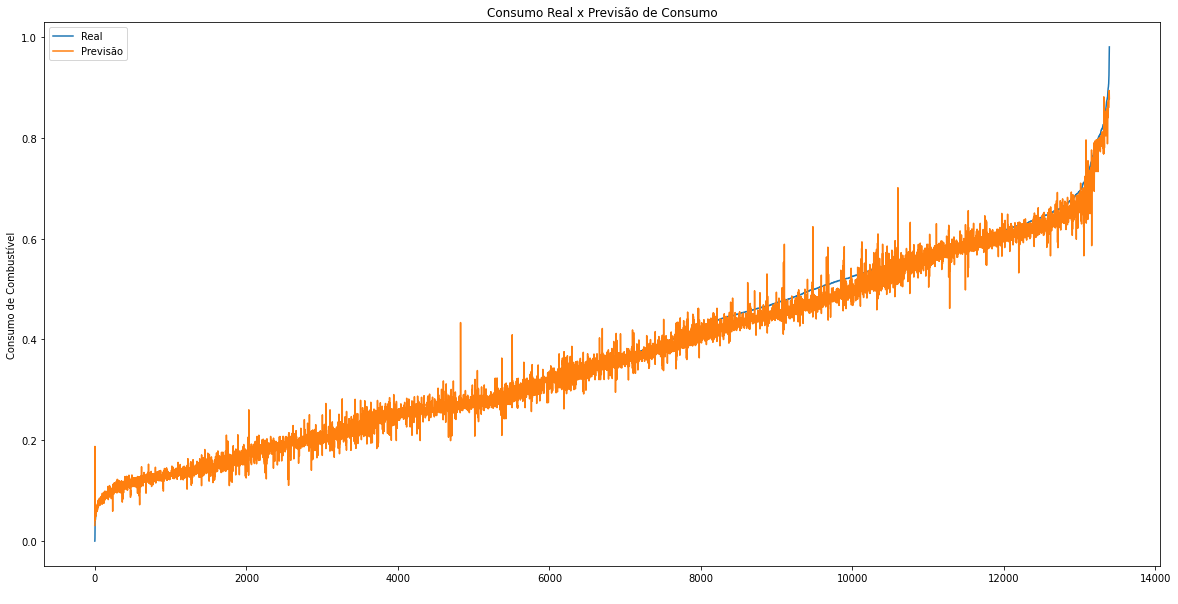

In [52]:
plt.figure(figsize=(20,10))
sns.lineplot(data=final, x='index', y='Real')
sns.lineplot(data=final, x='index', y='Previsão')
plt.title('Consumo Real x Previsão de Consumo')
plt.legend(labels=['Real', 'Previsão'])
plt.ylabel('Consumo de Combustível')
plt.xlabel(' ')
plt.show()

Podemos ver que de acordo com o gráfico, tivemos um ótimo comportamento do modelo em relação aos dados reais. Assim podemos ver que nosso modelo funciona muito bem para prever o consumo de combustível para o modelo do Airbus A320neo.

# Salvando o modelo em formato JSON

In [54]:
model_json = model.to_json()
with open('model_a320n.json', 'w') as json_file:
    json_file.write(model_json)
model.save_weights('pesos.h5')